In [1]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
import gym
from gym import spaces
import gym_dynamic_set_packing
import time

In [3]:
np.finfo(np.float32).eps.item()

1.1920928955078125e-07

In [4]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## training loop code

below is the code for the training loop. after that are definitions of two simple agents.

In [47]:
def train_loop(env, agent, episode_count, batches_per_episode, max_steps, quiet=False):
    done = False
    ep_rewards = []

    for i in tqdm(range(episode_count)):
        reward = 0.0
        if not quiet:
            print('episode {}'.format(i))
        total_reward = 0.0
        history_dict = {
            'actions': [],
            'observations': [],
            'rewards': []
        }
        for batch_idx in range(batches_per_episode):
            curr_obs = []
            curr_act = []
            curr_reward = []
            ob = env.reset()
            for i in range(max_steps):
                curr_obs.append(ob)
                action = agent.act(ob, reward, done)
                curr_act.append(action)
                ob, reward, done, _ = env.step(action)
                curr_reward.append(reward)
                if not quiet:
                    print('action taken: {}, reward: {}, new state: {}'.format(action, reward, env.render()))
            history_dict['observations'].append(np.stack(curr_obs,axis=0))
            history_dict['actions'].append(curr_act)
            history_dict['rewards'].append(curr_reward)
        total_reward = np.sum(history_dict['rewards']) / batches_per_episode
        agent.learn(history_dict)
        history_dict = None
        if not quiet:
            print('total episode reward: {}'.format(total_reward))
        ep_rewards.append(total_reward)
    return ep_rewards

## agents

In [48]:
class RandomMatchAgent:
    "A simple agent for the 0/1 problem that always matches."
    def __init__(self, match_prob):
        self.policy_dist = torch.distributions.Categorical(torch.tensor([1 - match_prob, match_prob], dtype=torch.float32))
        self.action_space = spaces.Discrete(2)

    def act(self, observation, reward, done):
        action_sample = self.policy_dist.sample()
        return action_sample.item()
    
    def learn(self, history_dict):
        pass

In [49]:
def discounted_episode_returns(rewards, gamma=0.99, standardize=False):
    """
    Given a sequence of rewards, returns the sequence
    of the discounted returns (G_t) at each time step,
    with discount rate gamma (default 0.999).
    """
    # thanks to yuhao for writing this code for another project
    length = len(rewards)
    discounts = [gamma**x for x in range(length)]
    result = [np.dot(discounts[:length-i], rewards[i:]) for i in range(length)]
    result_np = np.array(result, dtype='float32')

    if standardize:
        result_np = (result_np - result_np.mean()) / (result_np.std() + 1e-7)
    return result_np

In [72]:
def pg_target(policy_dist, rewards, action_trajectory):
    """
    The policy gradient target loss (without baseline). Note it should be negative because
    optimizers minimize by default. Rewards should be cumulative and discounted.
    All inputs should already be tensors, not lists or np arrays.
    """
    return torch.mean(-policy_dist.log_prob(action_trajectory)*rewards)

In [67]:
class LinearMatchAgent:
    def __init__(self, observation_shape, gamma=0.99, gpu=False):
        self.action_space = spaces.Discrete(2)
        
        self.policy_net = nn.Sequential(
            nn.Linear(observation_shape, 2, bias=False),
            nn.Softmax())
        self.value_net = nn.Sequential(
            nn.Linear(observation_shape, 1, bias=True),
        )

        self.gpu = gpu
        if gpu:
            self.policy_net.cuda()
            self.value_net.cuda()
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device('cpu')
        self.optimizer = torch.optim.Adam(list(self.policy_net.parameters()) + list(self.value_net.parameters()))
        self.gamma = gamma
    
    def policy(self, observation_batch):
        return torch.distributions.Categorical(probs=self.policy_net(observation_batch))
    def value(self, observation_batch):
        return self.value_net(observation_batch)

    def act(self, observation, reward, done):
        "Act on a single observation, return an action."
        observation_as_batch = torch.tensor(np.expand_dims(observation, 0), dtype=torch.float32, requires_grad=False, device=self.device)
        action_sample = self.policy(observation_as_batch).sample().detach().cpu().numpy()
        return action_sample[0]
    
    def learn(self, history_dict):
        """
        Perform the policy gradient update with its optimizer and policy.
        
        history_dict in general contains batches of episodes; we flatten these out
        into one enormous batch (as long as discounting of rewards is done correctly, the policy gradient loss
        doesn't care where each example came from).
        """
        
        # discounted returns, flattened out
        disc_returns = torch.as_tensor(np.concatenate([discounted_episode_returns(r, gamma=self.gamma) for r in history_dict['rewards']]), dtype=torch.float32, device=self.device)
        observations_tensor = torch.as_tensor(np.vstack(history_dict['observations']), dtype=torch.float32, device=self.device)
        actions_tensor = torch.as_tensor(np.concatenate(history_dict['actions']), dtype=torch.float32, device=self.device)
        #print(disc_returns)
        #print(observations_tensor)
        #print(actions_tensor)
        self.optimizer.zero_grad()
        policy_dists = self.policy(observations_tensor)
        value_estimates = self.value(observations_tensor)
        delta = disc_returns - value_estimates
        value_loss = delta.pow(2).mean() # delta.pow(2) instead?
        
        policy_loss = pg_target(policy_dists,
                             disc_returns,
                             actions_tensor)
        global_pol_loss.append(policy_loss.item())
        torch.autograd.backward([policy_loss, value_loss])
        self.optimizer.step()

## adversary example (fast, testing)

In [81]:
env_example = gym.make('CartPole-v0')
ag = LinearMatchAgent(env_example.observation_space.shape[0], gamma=0.999)
small_orig_weight = ag.policy_net[0].weight.detach().numpy().copy()
#small_orig_bias = ag.policy_net[0].bias.detach().numpy().copy()
ep_rewards = train_loop(env_example, ag, 3,1, 10, quiet=True)

In [65]:
env_example = gym.make('DynamicSetPacking-adversarial-v0')
ag = LinearMatchAgent(env_example.observation_space.shape[0], gamma=0.999)
small_orig_weight = ag.policy_net[0].weight.detach().numpy().copy()
#small_orig_bias = ag.policy_net[0].bias.detach().numpy().copy()
ep_rewards = train_loop(env_example, ag, 3,1, 10, quiet=False)

episode 0
action taken: 1, reward: 0.0, new state: [1. 1. 0. 0. 0.]
action taken: 1, reward: 2.0, new state: [0. 0. 1. 1. 1.]
action taken: 1, reward: 0.0, new state: [0. 0. 0. 0. 0.]
action taken: 0, reward: 0.0, new state: [1. 1. 0. 0. 0.]
action taken: 1, reward: 2.0, new state: [0. 0. 1. 1. 1.]
action taken: 0, reward: 0.0, new state: [0. 0. 0. 0. 0.]
action taken: 1, reward: 0.0, new state: [1. 1. 0. 0. 0.]
action taken: 1, reward: 2.0, new state: [0. 0. 1. 1. 1.]
action taken: 0, reward: 0.0, new state: [0. 0. 0. 0. 0.]
action taken: 1, reward: 0.0, new state: [1. 1. 0. 0. 0.]
tensor(20.5071, grad_fn=<SumBackward0>)
total episode reward: 6.0
episode 1
action taken: 1, reward: 0.0, new state: [1. 1. 0. 0. 0.]
action taken: 1, reward: 2.0, new state: [0. 0. 1. 1. 1.]
action taken: 1, reward: 0.0, new state: [0. 0. 0. 0. 0.]
action taken: 0, reward: 0.0, new state: [1. 1. 0. 0. 0.]
action taken: 0, reward: 0.0, new state: [1. 1. 1. 1. 1.]
action taken: 0, reward: 0.0, new state: [0.

## adversary example (long)

In [88]:
env_example = gym.make('CartPole-v0')
lin_ag = LinearMatchAgent(env_example.observation_space.shape[0], gamma=0.9999, gpu=False)
orig_weight = lin_ag.policy_net[0].weight.detach().numpy().copy()
#orig_bias = lin_ag.policy_net[0].bias.detach().numpy().copy()
ep_rewards = train_loop(env_example, lin_ag, 500, 8,100, quiet=True)

In [54]:
env_example = gym.make('DynamicSetPacking-adversarial-v0')
lin_ag = LinearMatchAgent(env_example.observation_space.shape[0], gamma=0.9999, gpu=False)
orig_weight = lin_ag.policy_net[0].weight.detach().numpy().copy()
#orig_bias = lin_ag.policy_net[0].bias.detach().numpy().copy()
ep_rewards = train_loop(env_example, lin_ag, 3000, 8,10, quiet=True)

KeyboardInterrupt: 

In [73]:
global_pol_loss = []
env_example = gym.make('DynamicSetPacking-adversarial-v0')
lin_ag = LinearMatchAgent(env_example.observation_space.shape[0], gamma=0.9999, gpu=False)
lin_ag.policy_net[0].weight.data = torch.Tensor([[1.3261, 1.1460,  -0.8547,  -0.5015,  -0.9008],
        [ 1.4077,  0.7449, 0.2461, 1.0496, 0.9913]])
orig_weight = lin_ag.policy_net[0].weight.detach().numpy().copy()
#orig_bias = lin_ag.policy_net[0].bias.detach().numpy().copy()
ep_rewards = train_loop(env_example, lin_ag, 3000, 8,10, quiet=True)

36.50475

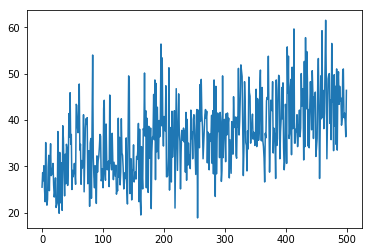

In [89]:
plt.plot(ep_rewards)
np.mean(ep_rewards)

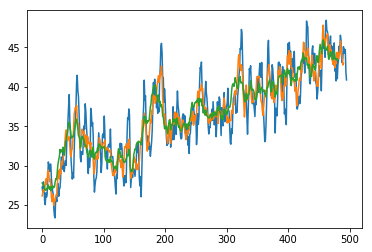

In [90]:
plt.plot(running_mean(ep_rewards, 5))
plt.plot(running_mean(ep_rewards, 10))
plt.plot(running_mean(ep_rewards, 20))

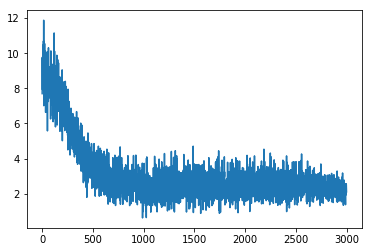

In [76]:
plt.plot(global_pol_loss)

In [29]:
np.max(ep_rewards)

114.0

In [30]:
lin_ag.policy_net[0].weight

Parameter containing:
tensor([[ 1.0433e+00,  8.6321e-01,  4.6712e-02,  3.9991e-01,  6.1131e-04],
        [ 1.6905e+00,  1.0277e+00, -6.5531e-01,  1.4819e-01,  8.9889e-02]],
       requires_grad=True)

In [25]:
lin_ag.policy_net[0].bias

In [ ]:
orig_weight

In [37]:
lin_ag.policy_net(torch.Tensor([1.0,1.0,1.0,1.0,1.0]))

tensor([0.5132, 0.4868], grad_fn=<SoftmaxBackward>)

In [ ]:
plt.plot(running_mean(ep_rewards, 5))
plt.plot(running_mean(ep_rewards, 10))
plt.plot(running_mean(ep_rewards, 20))

In [ ]:
class FixedMatchAgent(LinearMatchAgent):
    def __init__(self, observation_shape, weight, bias, gamma=0.99):
        super(FixedMatchAgent, self).__init__(observation_shape, gamma=gamma, gpu=False)
        self.policy_net[0].weight.data = weight
        self.policy_net[0].bias.data = bias

    def learn(self, d):
        pass

In [ ]:

env_example = gym.make('DynamicSetPacking-adversarial-v0')
smart_ag = FixedMatchAgent(env_example.observation_space.shape[0],
                     torch.Tensor([[0.0,0.0,0.0], [0.0,0.0,2.0]]),
                     torch.Tensor([-1.0,0.0]),
                     gamma=0.9999)


In [ ]:
orig_ag = FixedMatchAgent(env_example.observation_space.shape[0],
                     torch.Tensor(orig_weight),
                     torch.Tensor(orig_bias),
                     gamma=0.9999)
trained_ag = FixedMatchAgent(env_example.observation_space.shape[0],
                     torch.Tensor(lin_ag.policy_net[0].weight.detach().clone()),
                     torch.Tensor(lin_ag.policy_net[0].bias.detach().clone()),
                     gamma=0.9999)

In [ ]:
trained_ag.policy_net(torch.Tensor([5.0,5.0,0.0]))

In [ ]:
orig_ag.policy_net(torch.Tensor([1.0,1.0,5.0]))

In [ ]:
smart_ag.policy_net(torch.Tensor([1.0,1.0,4.0]))

In [ ]:
smart_ep_rewards = train_loop(env_example, smart_ag, 300, 8, 50, quiet=True)

In [ ]:
orig_ep_rewards = train_loop(env_example, orig_ag, 300, 8, 50, quiet=True)

In [ ]:
trained_ep_rewards = train_loop(env_example, trained_ag, 300, 8, 50, quiet=True)

In [ ]:
greedy = RandomMatchAgent(1.0)
greedy_ep_rewards = train_loop(env_example, greedy, 300, 8, 50, quiet=True)

In [ ]:
np.mean(greedy_ep_rewards)

In [ ]:
np.mean(smart_ep_rewards)

In [ ]:
np.mean(orig_ep_rewards)

In [ ]:
np.mean(trained_ep_rewards)

In [ ]:
class LinearMatchAgentOld:
    def __init__(self, observation_shape, gamma=0.99, gpu=False):
        self.action_space = spaces.Discrete(2)
        
        self.policy_net = nn.Sequential(
            nn.Linear(observation_shape, 2, bias=True),
            nn.Softmax())
        self.gpu = gpu
        if gpu:
            self.policy_net.cuda()
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device('cpu')
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=1e-2)
        self.gamma = gamma
    
    def policy(self, observation_batch):
        return torch.distributions.Categorical(probs=self.policy_net(observation_batch))
    
    def act(self, observation, reward, done):
        "Act on a single observation, return an action."
        observation_as_batch = torch.tensor(np.expand_dims(observation, 0), dtype=torch.float32, requires_grad=False, device=self.device)
        action_sample = self.policy(observation_as_batch).sample().detach().cpu().numpy()
        return action_sample[0]
    
    def learn(self, history_dict):
        """
        Perform the policy gradient update with its optimizer and policy.
        
        history_dict in general contains batches of episodes; we flatten these out
        into one enormous batch (as long as discounting of rewards is done correctly, the policy gradient loss
        doesn't care where each example came from).
        """
        
        # discounted returns, flattened out
        disc_returns = torch.as_tensor(np.concatenate([discounted_episode_returns(r, gamma=self.gamma) for r in history_dict['rewards']]), dtype=torch.float32, device=self.device)
        observations_tensor = torch.as_tensor(np.vstack(history_dict['observations']), dtype=torch.float32, device=self.device)
        actions_tensor = torch.as_tensor(np.concatenate(history_dict['actions']), dtype=torch.float32, device=self.device)
        
        self.optimizer.zero_grad()
        policy_dists = self.policy(observations_tensor)
        loss = pg_target(policy_dists,
                             disc_returns,
                             actions_tensor)
        loss.backward()
        self.optimizer.step()